In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
metrics_df = pd.read_csv(
    "/home/peter/Documents/uni/FIN-Dataset/hallway/draco/metrics/draco-hallway.csv"
)

In [8]:
metrics_df

,file,bpp,enc_file_size_bits,time_dec_ns,num_points,time_enc_ns,Symmetric Similarity
0,T0-108.ply,32.148148,3472,3203166,108,2268848,0.999055
1,T1-330.ply,14.206061,4688,6778865,330,5379192,0.997570
2,T2-663.ply,11.028658,7312,6827248,663,7456942,0.963822
3,T3-6474.ply,6.921223,44808,8584859,6474,12372344,0.848192
4,T4-14646.ply,5.857162,85784,10131603,14646,16662570,0.847943
...,...,...,...,...,...,...,...
164,T164-892788.ply,3.053446,2726080,144703536,892788,247235653,0.848486
165,T165-896679.ply,3.043114,2728696,129159396,896679,150960756,0.848384
166,T166-904530.ply,3.045471,2754720,36834492,904530,254789230,0.848337
167,T167-908724.ply,3.060115,2780800,143336002,908724,111849892,0.848503


In [23]:
bpps = metrics_df["bpp"]
enc_size = metrics_df["enc_file_size_bits"]/8000
time_enc = metrics_df["time_enc_ns"]/10**9
time_dec = metrics_df["time_dec_ns"]/10**9
points = metrics_df["num_points"]
similarity = metrics_df["Symmetric Similarity"]
x = np.arange(metrics_df.index.size)

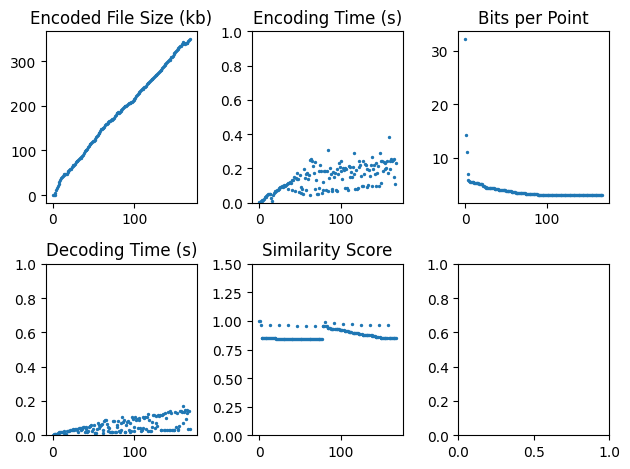

In [47]:
fig, axs = plt.subplots(2,3)

axs[0, 0].scatter(x, enc_size, s=2)
axs[0, 0].set_title("Encoded File Size (kb)")
axs[0, 1].scatter(x, time_enc, s=2)
axs[0, 1].set_title("Encoding Time (s)")
axs[1, 0].scatter(x, time_dec, s=2)
axs[1, 0].set_title("Decoding Time (s)")
axs[1, 1].scatter(x, similarity, s=2)
axs[1, 1].set_title("Similarity Score")
axs[0, 2].scatter(x, bpps, s=2)
axs[0, 2].set_title("Bits per Point")
axs[1, 1].set_ylim([0, 1.5])
axs[0, 1].set_ylim([0, 1])
axs[1, 0].set_ylim([0, 1])
fig.tight_layout()